# Тестирование работы рекуррентных нейронных сетей

In [2]:
import sys
import os
current_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, project_root)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
rng = np.random.default_rng(51)
from sklearn.preprocessing import OneHotEncoder
from recurrent_nn.RNN import RMLP, LSTM, GRU


## Загрузка, разведочный анализ и подготовка данных

In [4]:
dfm=pd.read_csv('../data/Steel_industry_data.csv', delimiter = ",")

In [5]:
dfm.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


Посмотрим на распределения признаков:

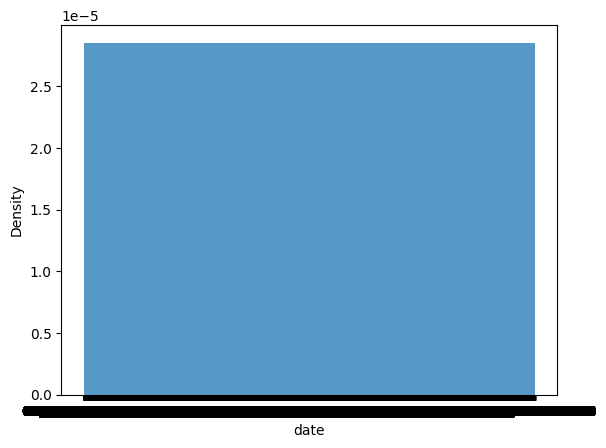

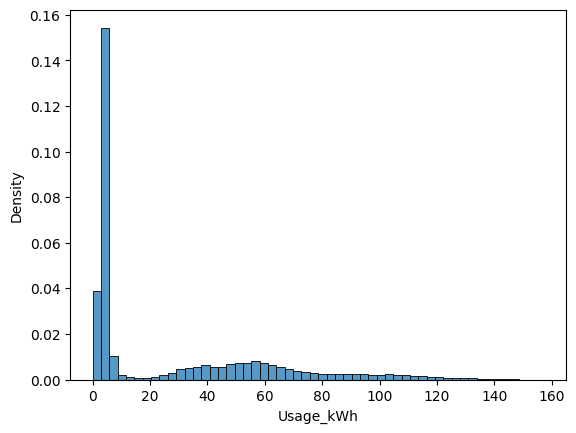

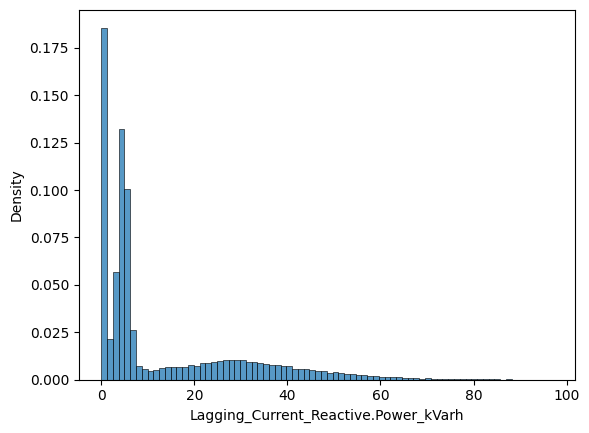

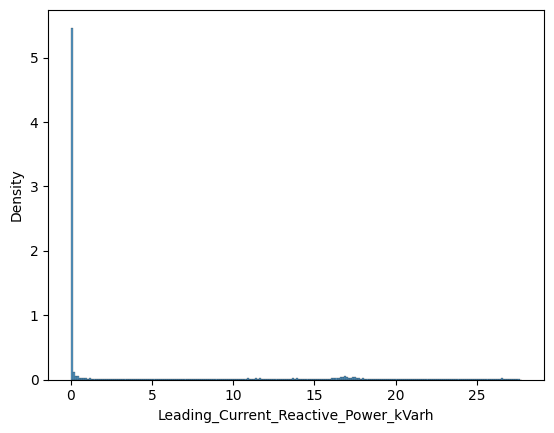

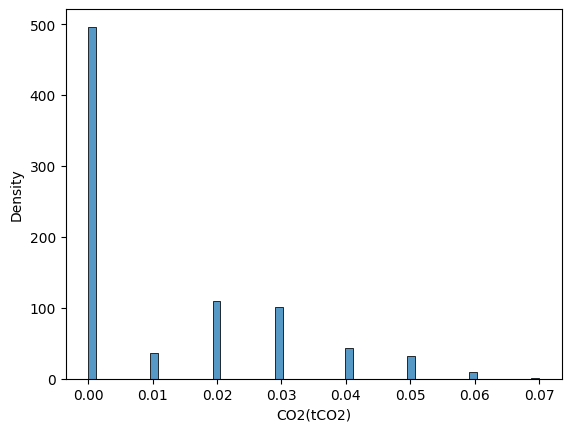

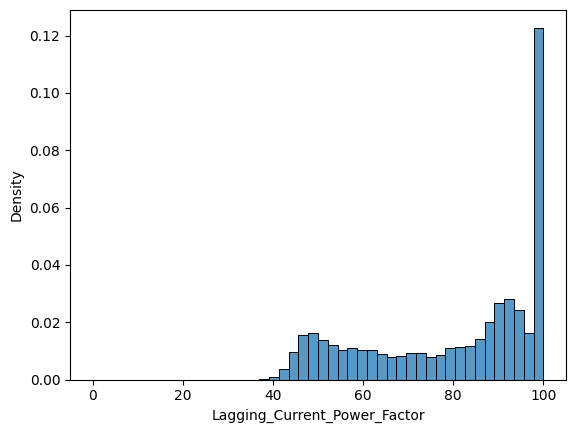

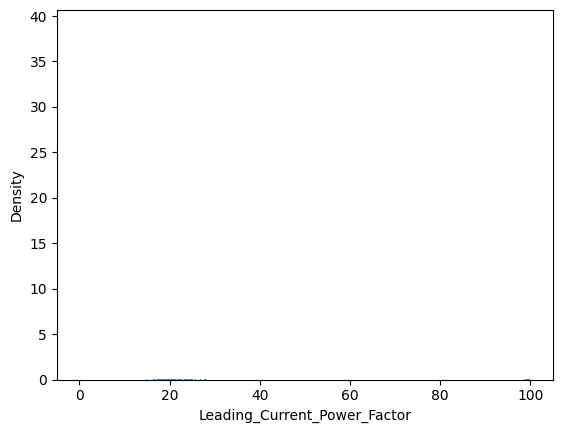

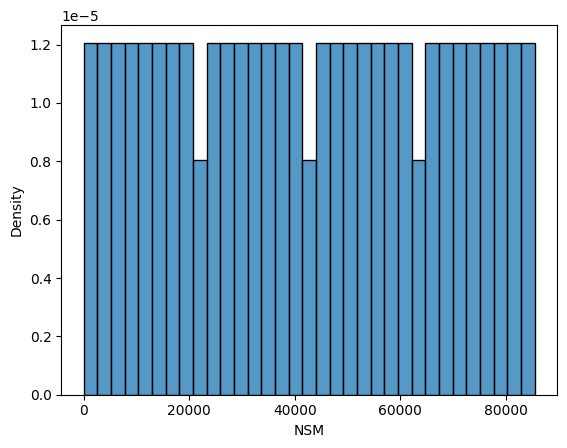

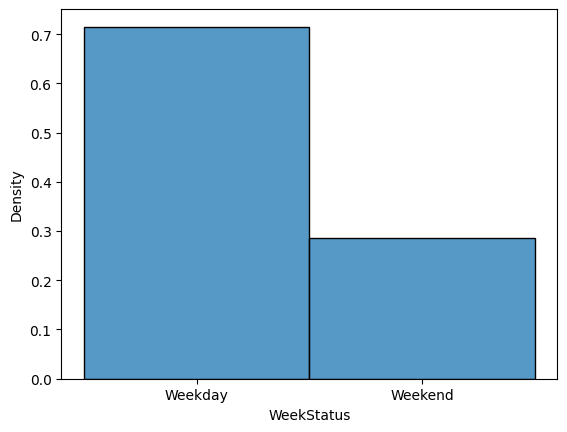

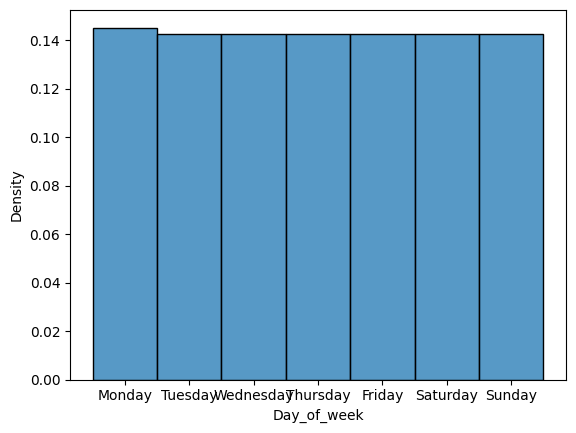

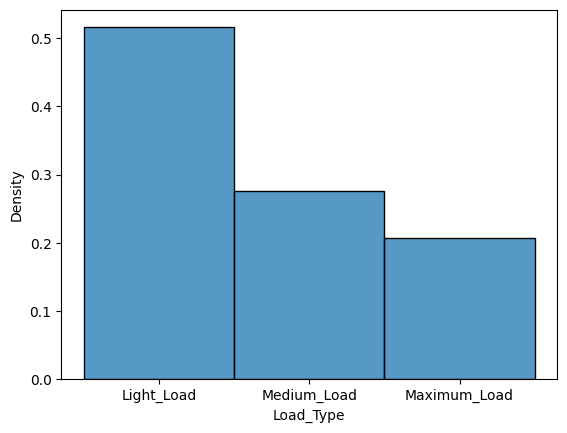

In [7]:
for i in dfm.columns:
    plt.figure(i)
    sns.histplot(dfm[i],stat="density")
    plt.show()

Как таковых выбросов не наблюдается

Последние 3 признака являются категориальными, применим one-hot-encoding для них

In [6]:
onehotencoder = OneHotEncoder(sparse_output=False)

In [7]:
X=onehotencoder.fit_transform(dfm.iloc[:,8:11])
X_2=dfm.iloc[:,2:8].to_numpy()
X=np.concatenate((X_2,X),axis=1)
y=dfm[['Usage_kWh']]
y=y.to_numpy().reshape(-1)

Стандартизуем данные:

In [8]:
mins_x=np.min(X,axis=0)
maxs_x=np.max(X,axis=0)
mins_y=np.min(y)
maxs_y=np.max(y)
X_st=(X-mins_x)/(maxs_x-mins_x)
y_st=(y-mins_y)/(maxs_y-mins_y)

Разобьём выборку на тестовую и тренировочную по батчам размера 4

In [9]:
X_b=X_st.reshape(int(X_st.shape[0]/4),4,X_st.shape[1])
y_b=y_st.reshape(-1,4)
X_tr, X_tst, y_tr, y_tst = train_test_split(X_b, y_b, test_size=0.3, random_state=42) 

In [10]:
X_train=X_tr.reshape(-1,18)
X_test=X_tst.reshape(-1,18)
y_train=y_tr.reshape(-1)
y_test=y_tst.reshape(-1)

# Обучение нейронных сетей

In [11]:
from utils.metrics import R_square, mse, rmse

## RMLP

In [11]:
rm=RMLP((18,50,1))

Обучение идёт при помощи sgd c шагом 10^-4. При числе эпох, большем 20, начинается переобучение

In [12]:
loss_rm=rm.train(X_train,y_train,epochs=20)

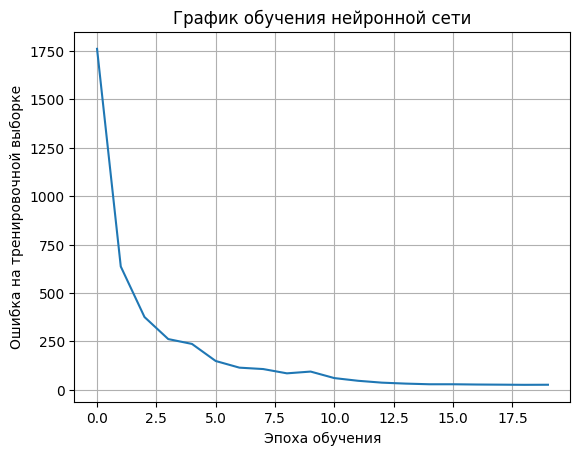

In [13]:
plt.plot(loss_rm)
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка на тренировочной выборке')
plt.title('График обучения нейронной сети')
plt.grid()
plt.show()

Посмотрим точности на тренировочной и тестовой выборках при предсказании по батчам:

In [14]:
predict_test_rmlp=rm.predict_2(X_test)
predict_train_rmlp=rm.predict_2(X_train)
print('R^2 на тренирововочной выборке:', R_square(predict_train_rmlp,y_train))
print('R^2 на тестовой выборке:', R_square(predict_test_rmlp, y_test))

R^2 на тренирововочной выборке: 0.9528367971162526
R^2 на тестовой выборке: 0.9517047076321977


Теперь посмотрим метрики на всём ряду:

In [15]:
predict_rmlp=rm.predict(X_st)
print('R^2 на всём ряду:', R_square(predict_rmlp,y_st))
print('MSE на всём ряду:', mse(predict_rmlp,y_st))
print('RMSE на всём ряду:', rmse(predict_rmlp,y_st))

R^2 на всём ряду: 0.6203890587834677
MSE на всём ряду: 0.017186128274865837
RMSE на всём ряду: 0.1310958743624903


Теперь посмотрим графики реального и спрогнозированного рядов:

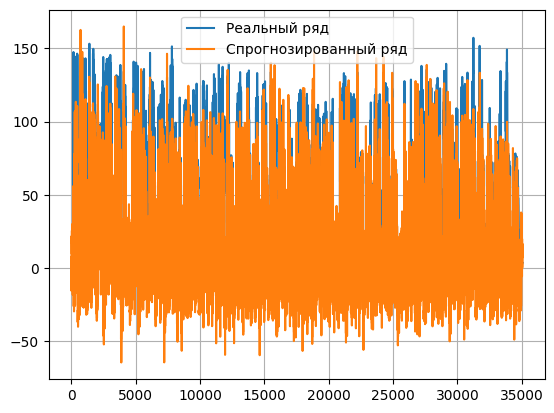

In [16]:
plt.plot(y)
plt.plot(predict_rmlp*((maxs_y-mins_y)+mins_y))
plt.legend(['Реальный ряд', 'Спрогнозированный ряд'])
plt.grid()
plt.show()

## LSTM

In [18]:
lstm=LSTM((18,50,1))


В данном случае обучение идёт через ADAM с шагом 0.001, эпох максимум 10, поскольку данная модель очень быстро переобучается

In [19]:
loss_lstm=lstm.train(X_train,y_train,epochs=8)

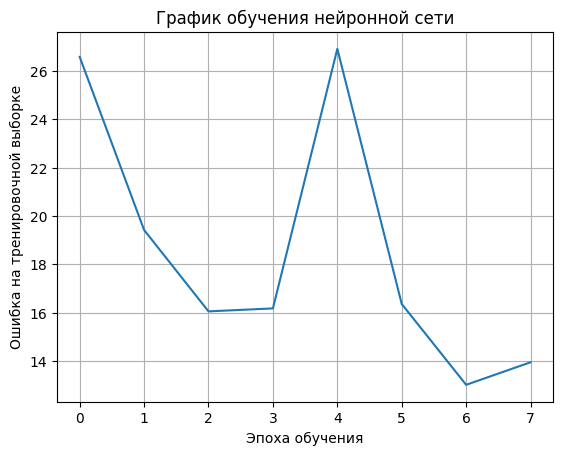

In [20]:
plt.plot(loss_lstm)
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка на тренировочной выборке')
plt.title('График обучения нейронной сети')
plt.grid()
plt.show()

Посмотрим точности на тренировочной и тестовой выборках:

In [21]:
predict_test_lstm=lstm.predict_2(X_test)
predict_train_lstm=lstm.predict_2(X_train)
print('R^2 на тренирововочной выборке:', R_square(predict_train_lstm,y_train))
print('R^2 на тестовой выборке:', R_square(predict_test_lstm, y_test))

R^2 на тренирововочной выборке: 0.974669173888667
R^2 на тестовой выборке: 0.974310295657055


Посмотрим точность на всём ряду:

In [22]:
predict_lstm=lstm.predict(X_st)
print('R^2 на всём ряду:', R_square(predict_lstm,y_st))
print('MSE на всём ряду:', mse(predict_lstm,y_st))
print('RMSE на всём ряду:', rmse(predict_lstm,y_st))

R^2 на всём ряду: 0.9631700846212342
MSE на всём ряду: 0.0016674009659033424
RMSE на всём ряду: 0.04083382134828116


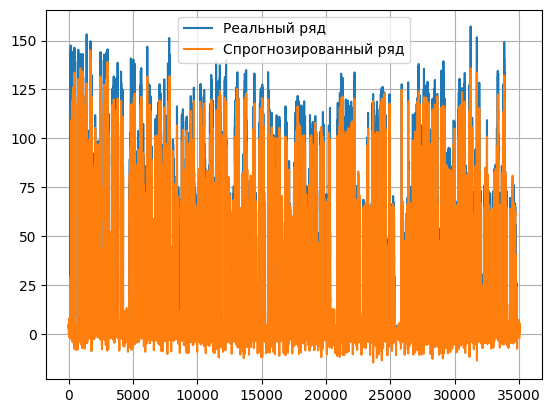

In [23]:
plt.plot(y)
plt.plot(predict_lstm*((maxs_y-mins_y)+mins_y))
plt.legend(['Реальный ряд', 'Спрогнозированный ряд'])
plt.grid()
plt.show()

## GRU

In [56]:
gru=GRU((18,50,1))

Обучение идёт через sgd с шагом 0.0001, при числе эпох, большем 25, идёт переобучение

In [57]:
loss_gru=gru.train(X_train,y_train,epochs=10, lr=0.001, adam=True)

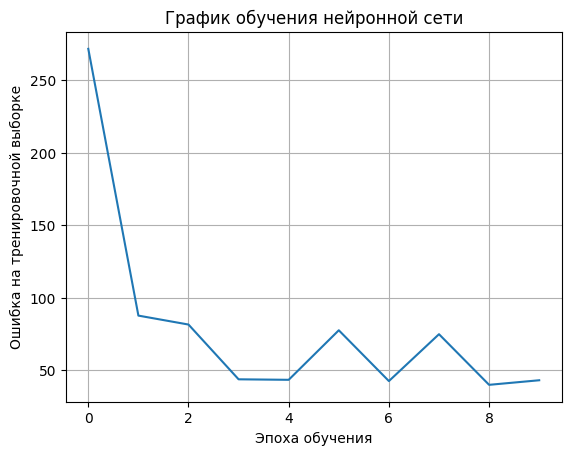

In [58]:
plt.plot(loss_gru)
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка на тренировочной выборке')
plt.title('График обучения нейронной сети')
plt.grid()
plt.show()

Посмотрим точности на тестовой и обучающей выборках:

In [59]:
predict_test_gru=gru.predict_2(X_test)
predict_train_gru=gru.predict_2(X_train)
print('R^2 на тренирововочной выборке:', R_square(predict_train_gru,y_train))
print('R^2 на тестовой выборке:', R_square(predict_test_gru, y_test))

R^2 на тренирововочной выборке: 0.921741392216836
R^2 на тестовой выборке: 0.920019856213402


Посмотрим метрики на всём ряду:

In [60]:
predict_gru=gru.predict(X_st)
print('R^2 на всём ряду:', R_square(predict_gru,y_st))
print('MSE на всём ряду:', mse(predict_gru,y_st))
print('RMSE на всём ряду:', rmse(predict_gru,y_st))

R^2 на всём ряду: 0.8369925703896907
MSE на всём ряду: 0.007379836276744632
RMSE на всём ряду: 0.08590597346369246


Рассмотрим графики:

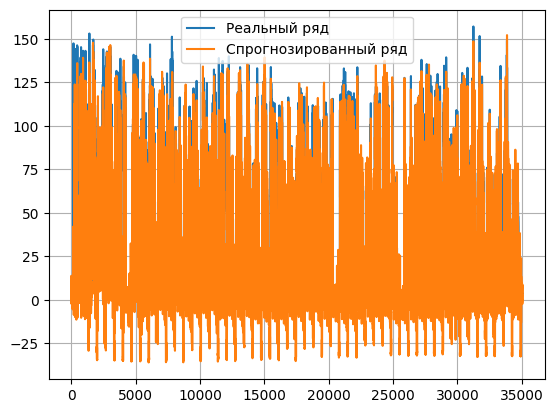

In [62]:
plt.plot(y)
plt.plot(predict_gru*((maxs_y-mins_y)+mins_y))
plt.legend(['Реальный ряд', 'Спрогнозированный ряд'])
plt.grid()
plt.show()